In [1]:
import pandas as pd
import pymysql
import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from functools import reduce
from data_utils import *
from etl import user_info_features
from collections import defaultdict, OrderedDict
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
pd.set_option('max_columns',1000)
pd.set_option('max_rows', 1000)

In [2]:
conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')

base_user_info = pd.read_sql_query('select * from base_user_info', conn)
user_feature_df = user_info_features(base_user_info)

In [4]:
base_user_fans = pd.read_sql_query('select * from base_user_fans', conn)
fans_active_week_rate, _ = vectorize_json_fixed_length(base_user_fans, 'fans_active_week_rate')
male_age_rate, male_ar_names = vectorize_json_fixed_length(base_user_fans, 'male_age_rate')
female_age_rate, female_ar_names = vectorize_json_fixed_length(base_user_fans, 'female_age_rate')
fans_active_day_rate, fans_day_names = vectorize_json_fixed_length(base_user_fans, 'fans_active_day_rate')
word_cloud,word2index = vectorize_json_variable_length(base_user_fans, 'comment_cloud')
city_rate,city_rate_name = vectorize_json_variable_length(base_user_fans, 'city_rate')
base_user_fans_small = base_user_fans[['id','create_time','male_rate','female_rate']]
city_rate_level, city_rate_level_name = vectorize_json_variable_length(base_user_fans,'city_level_rate')

In [5]:
live_review = pd.read_sql_query('select * from base_live_viewer', conn)
l_male_age_rate = vectorize_json_fixed_length(live_review, 'male_age_rate')
l_female_age_rate = vectorize_json_fixed_length(live_review, 'female_age_rate')
l_wordcloud,_ = vectorize_json_variable_length(live_review, col = 'comment_cloud')
l_cityrate,_ = vectorize_json_variable_length(live_review, col = 'city_rate')
l_view_source , names= vectorize_json_variable_length(live_review,'viewer_source')
l_view_source = pd.DataFrame(l_view_source,columns = names.keys())

In [6]:
def label_sex(male_age_rate, female_age_rate, male_ar_names, female_ar_names):

    # combine sex and age
    sex_age = np.c_[male_age_rate, female_age_rate]

    # rename columns 
    male_ar_names = ['male_' + name for name in male_ar_names]
    female_ar_names = ['female_' + name for name in female_ar_names]

    # make a dataframe
    sex_age = pd.DataFrame(sex_age, columns = male_ar_names + female_ar_names)
    
    # kmeans clustering
    kmeans_sexage = KMeans(n_clusters = 6,random_state = 42)
    labels = kmeans_sexage.fit_predict(sex_age)
    
    # assign labels
    sex_age['id'] = base_user_fans['id'].copy()
    sex_age['label'] = labels
    sex_age = sex_age.rename(columns = {'label':'sex_label'})
    
    return sex_age[['id','sex_label']]

In [7]:
sex_age_df = label_sex(male_age_rate, female_age_rate, male_ar_names, female_ar_names)

In [8]:
def label_city_rate_level(city_rate_level, city_rate_level_name):
    
    # convert number to ratio
    city_rate_level = city_rate_level / city_rate_level.sum(axis = 1).reshape(-1,1)
    city_rate_level_df = pd.DataFrame(city_rate_level, columns  = city_rate_level_name)
    city_rate_level_df = city_rate_level_df.fillna(0)
    
    # kmeans clustering
    kmeans_sexage = KMeans(n_clusters = 7,random_state = 42)
    city_rate_labels = kmeans_sexage.fit_predict(city_rate_level_df)
    
    # city rate level label assign
    city_rate_level_df['id'] = base_user_fans['id'].copy()
    city_rate_level_df['label'] = city_rate_labels
    
    city_rate_level_df =city_rate_level_df.rename(columns = {'label':'city_rate_level'})
    return city_rate_level_df[['id','city_rate_level']]

In [9]:
city_rate_level_df = label_city_rate_level(city_rate_level, city_rate_level_name)

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [14]:
useful_features = [ col for col in user_feature_df.columns if not col.startswith('region')]
user_feature_df = user_feature_df[useful_features]
user_feature_df = user_feature_df.merge(city_rate_level_df, on = 'id',how = 'left').merge(sex_age_df, on = 'id', how = 'left')
city_level_1hot = pd.get_dummies(user_feature_df.city_rate_level,prefix='fans_city_level')
sex_age_1hot = pd.get_dummies(user_feature_df.sex_label, prefix  ='fans_sex_age')
user_feature_df = pd.concat([user_feature_df, city_level_1hot,sex_age_1hot],axis =1 ).drop(['city_rate_level','sex_label'], axis = 1)

In [94]:
numeric_features = ['fans',
                    'videos',
                    'index_number',
                    'likes']
selected_features = [col for col in user_feature_df.columns if not col in numeric_features +['id']]
selected_features =  [col for col in selected_features if not col.startswith('sex')]

In [95]:
df = user_feature_df[selected_features]

In [83]:
def clustering_inertials(vectors):
    inertials = []
    for i in range(2,20):
        kmeans = KMeans(n_clusters = i)
        kmeans.fit(StandardScaler().fit_transform(vectors))
        inertials.append(kmeans.inertia_)
    figsize(8,6)
    plt.title('N_clusters')
    plt.plot(inertials, marker = '.', markersize = 20,linewidth = 3)
    plt.grid(linestyle = '--')
    plt.show()

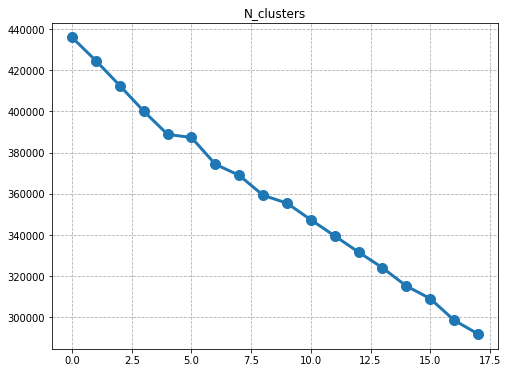

In [84]:
clustering_inertials(df)

In [97]:
from scipy.cluster.hierarchy import fcluster, linkage

In [103]:
sim_mat = linkage(df, method = 'complete',metric = 'cosine',optimal_ordering = False)

In [105]:
labels = fcluster(sim_mat, 20, 'maxclust')

In [93]:
# kmeans= KMeans(n_clusters = 15,random_state = 42)
# labels = kmeans.fit_predict(df)

In [86]:
# from collections import Counter

In [92]:
df['label'] = labels

In [88]:
test = pd.concat([df, base_user_info],axis = 1)

In [109]:
test[test.label == 3].head(100)

,tag_剧情,tag_少儿,tag_帅哥,tag_知识,tag_教育,tag_其他,tag_教学,tag_健康,tag_品味,tag_情感,tag_宠物,tag_食品,tag_舞蹈,tag_蓝V,tag_旅行,tag_音乐,tag_美女,tag_奇趣,tag_汽车,tag_家居,tag_政务,tag_种草,tag_职场,tag_科技,tag_动漫,tag_生活,tag_幽默,tag_影视,tag_母婴,tag_明星,tag_游戏,tag_美妆,tag_运动,tag_搭配,city_level_三线城市,city_level_Missing,city_level_五线城市,city_level_Others,city_level_一线城市,city_level_四线城市,city_level_二线城市,fans_city_level_0,fans_city_level_1,fans_city_level_2,fans_city_level_3,fans_city_level_4,fans_city_level_5,fans_city_level_6,fans_sex_age_0,fans_sex_age_1,fans_sex_age_2,fans_sex_age_3,fans_sex_age_4,fans_sex_age_5,label,id,create_time,name,douyin_id,sex,region,tag,introduction,fans,videos,index_number,cert,likes
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,100071114786,2020-06-24 10:32:12,旺仔,1047822055,未知,郑州,种草,感谢各位的关注🙏🙏🙏\n每天七点更新段子\n找我聊天📮：wangzai260,372000,65,841.9,\r\n,9803000
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,3,100071819280,2020-06-24 10:32:12,穿拖鞋的猫爷,maoye110,男,成都,家居,装修百晓生🧐🤔\n围脖&公号：穿拖鞋的猫爷,4175000,426,973.7,\r\n,17155000
61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,3,100074374856,2020-06-24 10:32:12,终极小腾,1049401268,男,北京,汽车,生活是一场奇妙的体验\n想看什么@终极小腾\n终极代驾主理人,1973000,40,890.8,None,6623000
65,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,100080497791,2020-06-24 10:32:12,北城很暖.,BCHN520,男,苏州,知识,后会有期,412000,402,782.0,None,2981000
67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,3,100083413401,2020-06-24 10:32:12,每日经济新闻,nbdnews,男,成都,政务,关注我，更有“财”\n中国主流财经全媒体,4164000,842,944.7,每日经济新闻官方抖音账号,30255000
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,100084734935,2020-06-24 10:32:12,游戏怪奇物语,Strange_Things,女,广州,游戏,说些游戏里的故事,1656000,316,880.6,\r\n,15301000
88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,3,100102568165,2020-06-24 10:32:12,搭配师阿莫,1193644702,男,杭州,搭配,关注我～🍑思林柏,783000,232,831.2,抖音好物推荐官,2291000
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,3,100120206838,2020-06-24 10:32:12,野行涛哥,UHAIFishing,男,北京,运动,钓过61个国家地区钓场\n资深游钓领队，全球钓鱼运动引领者\n跟着涛哥去钓鱼 +V：158 ...,2841000,608,915.2,抖音知识分享官,16979000
126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,3,100147308477,2020-06-24 10:32:12,车品会,W10182019,男,孝感,汽车,专注汽车用品,54000,663,696.0,None,381000
128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,100149058533,2020-06-24 10:32:12,舟舟的烦恼,1086573017,男,重庆,幽默,我的烦恼使你快乐👍\n♈️🌟bzbz7722,1553000,141,932.3,\r\n,37198000
